# Forecasting electricity consumption

This model analyzes past hourly data and uses time forecasting to predict the future consumption.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf

## 1. Data

### 1.1 Data ingestion and conversion

The dataset is provided by PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).


In [2]:
df = pd.read_csv('PJME_hourly.csv', index_col = [0], parse_dates = [0])

#sorting the dataset
df.sort_index(inplace = True)

In [3]:
# Splitting the dataset

def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

train, test = split_data(df, '01-Jan-2015')


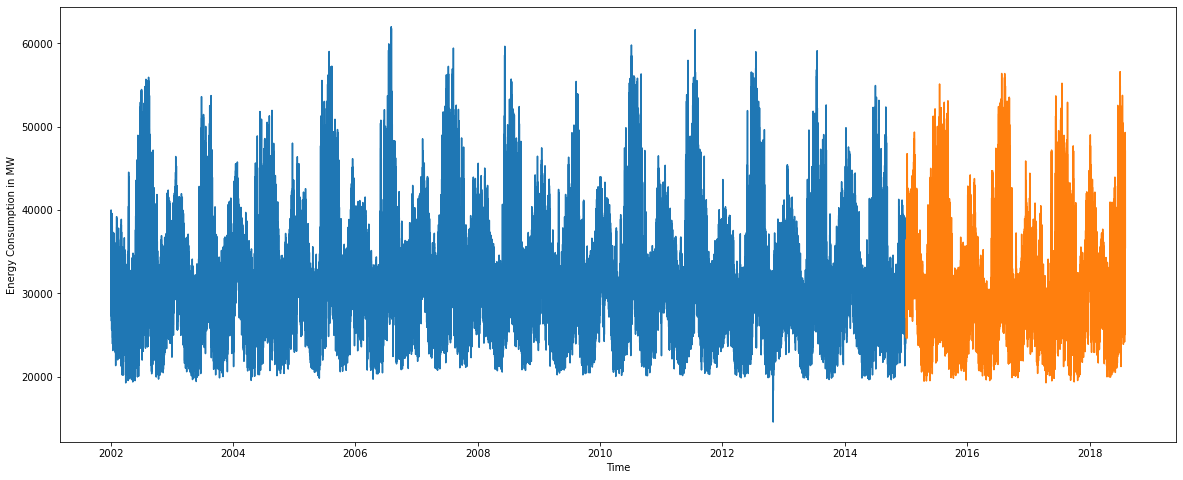

In [4]:
#Plotting the train and test data

plt.figure(figsize = (20,8))
plt.ylabel('Energy Consumption in MW')
plt.xlabel('Time')
plt.plot(train.index, train)
plt.plot(test.index, test)
plt.show()

The blue data is the training dataset and orange is the testing dataset.

Now we will need to create multiple columns to use them as features in the prediction model

### 1.2 Adding Features to data

In [5]:
def features(df):
    
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    merged_df = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return merged_df

In [6]:
X_train, y_train = features(train), train['PJME_MW']
X_test, y_test   = features(test), test['PJME_MW']

X_train.shape, y_train.shape

C:\Users\saadm\AppData\Local\Temp/ipykernel_16344/324014707.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((113927, 8), (113927,))

## 2. Model

In [7]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

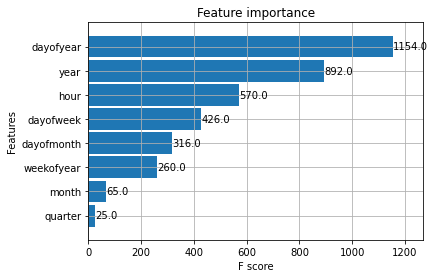

In [8]:
xgb.plot_importance(reg, height = 0.9)

## 3. Forecast

In [9]:
#Forecast on test set

X_test_pred = reg.predict(X_test)

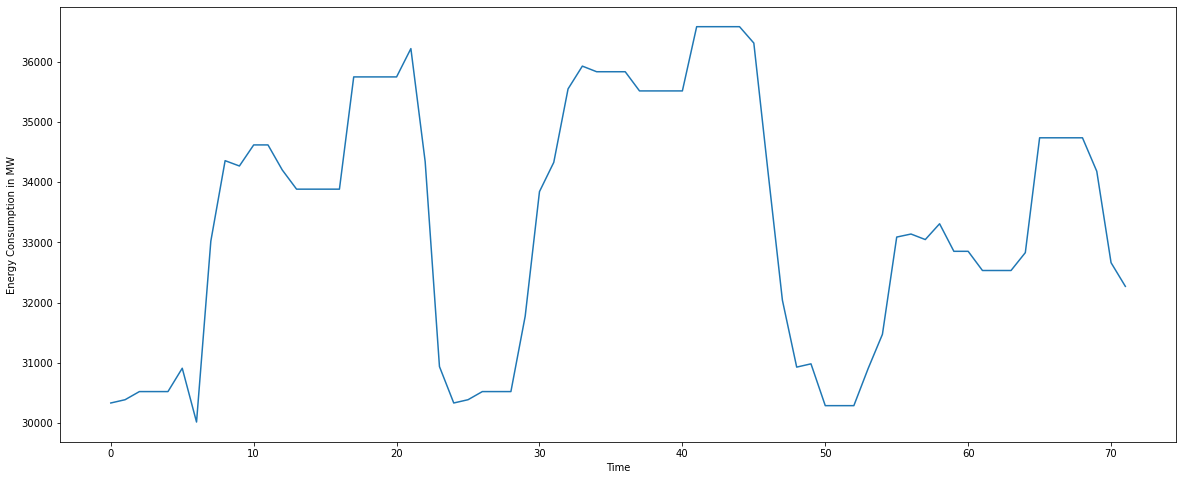

In [27]:
#Next 72 hour prediction

plt.figure(figsize = (20,8))
plt.ylabel('Energy Consumption in MW')
plt.xlabel('Time')
plt.plot(X_test_pred[:72]),
plt.show()

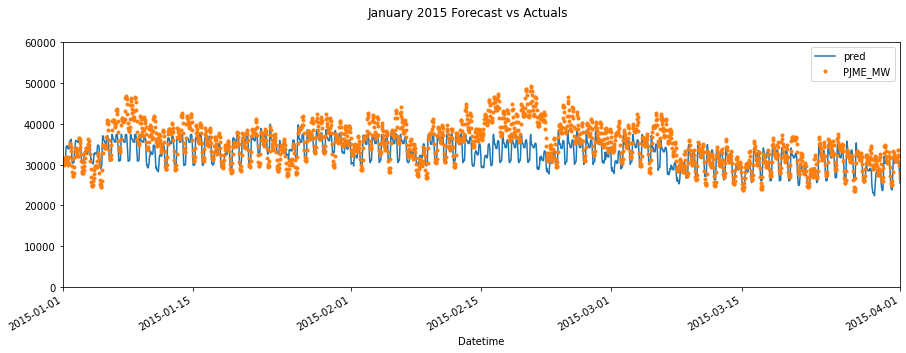

In [39]:
test['pred'] = X_test_pred

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = test[['pred','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='04-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [28]:
### Error calculation

mean_squared_error(y_true = y_test, y_pred = X_test_pred)

13960913.30565261

In [30]:
mean_absolute_error(y_true=y_test, y_pred=X_test_pred)

2757.2169004982866

In [35]:
# Mean absolute percentage error

y_true, y_pred = np.array(y_test), np.array(X_test_pred)
mape = np.mean(np.abs((y_pred - y_true)/y_true)) * 100
print('Mean Absolute Percentage Error is : ', round(mape,2), '%')

Mean Absolute Percentage Error is :  8.51 %


In [43]:
test[['hour', 'dayofmonth', 'month', 'year', 'PJME_MW', 'pred']]

,hour,dayofmonth,month,year,PJME_MW,pred
Datetime,,,,,,
2015-01-01 01:00:00,1,1,1,2015,31647.0,30334.513672
2015-01-01 02:00:00,2,1,1,2015,30755.0,30388.841797
2015-01-01 03:00:00,3,1,1,2015,30189.0,30523.792969
2015-01-01 04:00:00,4,1,1,2015,29890.0,30523.792969
2015-01-01 05:00:00,5,1,1,2015,30075.0,30523.792969
...,...,...,...,...,...,...
2018-08-02 20:00:00,20,2,8,2018,44057.0,41007.421875
2018-08-02 21:00:00,21,2,8,2018,43256.0,41007.421875
2018-08-02 22:00:00,22,2,8,2018,41552.0,38328.695312
